## Business Question

Why did customer satisfaction decrease in some regions despite stable sales?

## Hypotheses

1. Delivery delays negatively impact customer reviews in certain regions.
2. Some regions have systematically worse logistics performance.
3. Stable sales can hide declining customer experience.
4. (Optional) Category mix may amplify delivery issues in some regions.

## Analysis Design

To investigate the decrease in customer satisfaction, this analysis focuses on:

- Delivery performance, measured as the difference between actual and estimated delivery dates.
- Customer reviews as a proxy for satisfaction.
- Regional differences using customer state.
- Comparing logistics performance and satisfaction across regions.

The analysis uses delivered orders only, as non-delivered orders do not represent completed customer experiences.

## Data Loading and Initial Inspection

In [1]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("../../data/raw/olist")

orders = pd.read_csv(DATA_DIR / "olist_orders_dataset.csv")
reviews = pd.read_csv(DATA_DIR / "olist_order_reviews_dataset.csv")
customers = pd.read_csv(DATA_DIR / "olist_customers_dataset.csv")

orders.shape, reviews.shape, customers.shape

((99441, 8), (99224, 7), (99441, 5))

In [2]:
# Merge orders with reviews (left join to keep all orders)
orders_reviews = orders.merge(
    reviews,
    on="order_id",
    how="left"
)

orders_reviews.shape

(99992, 14)

In [3]:
# Merge with customers to get regional information
orders_full = orders_reviews.merge(
    customers[["customer_id", "customer_state"]],
    on="customer_id",
    how="left"
)

orders_full.shape

(99992, 15)

### Delivery delays negatively impact customer reviews ?

In [4]:
# Convert delivery dates to datetime
orders_full["order_delivered_customer_date"] = pd.to_datetime(
    orders_full["order_delivered_customer_date"]
)
orders_full["order_estimated_delivery_date"] = pd.to_datetime(
    orders_full["order_estimated_delivery_date"]
)

# Calculate delivery delay in days
orders_full["delivery_delay_days"] = (
    orders_full["order_delivered_customer_date"]
    - orders_full["order_estimated_delivery_date"]
).dt.days

orders_full[["delivery_delay_days"]].describe()

,delivery_delay_days
count,97005.000000
mean,-11.880790
std,10.183992
min,-147.000000
25%,-17.000000
50%,-12.000000
75%,-7.000000
max,188.000000


## Delivery Delay Analysis

Before analyzing customer satisfaction, we first explore delivery performance.
Delivery delay is defined as the difference between actual and estimated delivery dates.
Negative values indicate early deliveries, while positive values indicate delays.

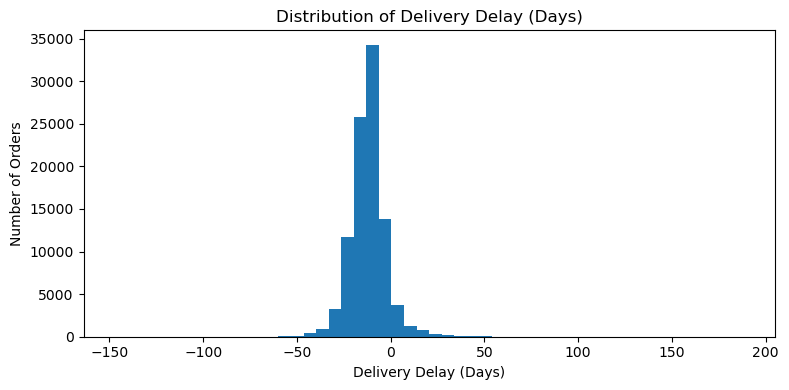

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(
    orders_full["delivery_delay_days"].dropna(),
    bins=50
)
plt.title("Distribution of Delivery Delay (Days)")
plt.xlabel("Delivery Delay (Days)")
plt.ylabel("Number of Orders")
plt.tight_layout()

plt.savefig("../reports/delivery_delay_distribution.png", dpi=150)
plt.show()

**Insight**

Most orders are delivered earlier than expected, indicating strong overall logistics performance.
However, the presence of delayed outliers suggests that customer dissatisfaction may be driven by localized issues rather than systemic failures.
This helps explain why global sales metrics can remain stable while customer satisfaction declines in specific cases.

In [6]:
# Relationship between delivery delay and review score
delay_vs_review = (
    orders_full
    .groupby("review_score")
    .agg(
        avg_delay=("delivery_delay_days", "mean"),
        median_delay=("delivery_delay_days", "median"),
        orders=("delivery_delay_days", "count")
    )
    .reset_index()
    .sort_values("review_score")
)

delay_vs_review

,review_score,avg_delay,median_delay,orders
0,1.0,-4.060580,-7.0,9409
1,2.0,-8.634818,-10.0,2941
2,3.0,-10.774052,-11.0,7962
3,4.0,-12.380840,-12.0,18987
4,5.0,-13.388153,-13.0,57060


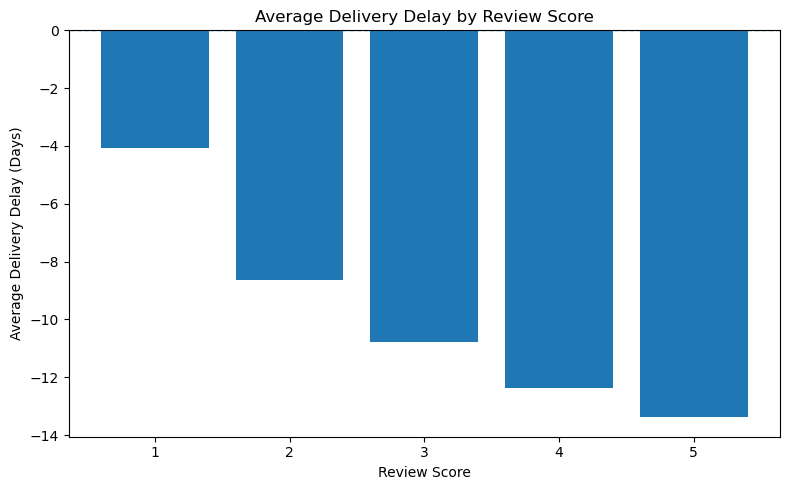

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.bar(
    delay_vs_review["review_score"],
    delay_vs_review["avg_delay"]
)

plt.axhline(0, linestyle="--", linewidth=1)

plt.xlabel("Review Score")
plt.ylabel("Average Delivery Delay (Days)")
plt.title("Average Delivery Delay by Review Score")

plt.tight_layout()

# 👇 CLAVE: guardar el gráfico
plt.savefig("../reports/delivery_delay_by_review_score.png", dpi=150)

plt.show()

**Interpretation:**  
Negative values indicate orders delivered earlier than estimated.  
Higher review scores are associated with earlier deliveries, while lower ratings correspond to deliveries closer to or past the estimated date.

### Regional differences

In [8]:
# Regional performance: delay and review score
regional_perf = (
    orders_full
    .groupby("customer_state")
    .agg(
        avg_delay=("delivery_delay_days", "mean"),
        avg_review=("review_score", "mean"),
        orders=("order_id", "count")
    )
    .reset_index()
    .sort_values("avg_review")
)

regional_perf.head(10)

,customer_state,avg_delay,avg_review,orders
21,RR,-17.292683,3.608696,46
1,AL,-8.713217,3.751208,417
9,MA,-9.640777,3.764075,751
24,SE,-10.020896,3.808023,350
13,PA,-14.054622,3.849174,981
5,CE,-10.818253,3.851016,1339
4,BA,-10.785212,3.860888,3397
18,RJ,-11.758110,3.874971,12930
16,PI,-11.297694,3.920570,496
15,PE,-13.354738,4.011543,1663


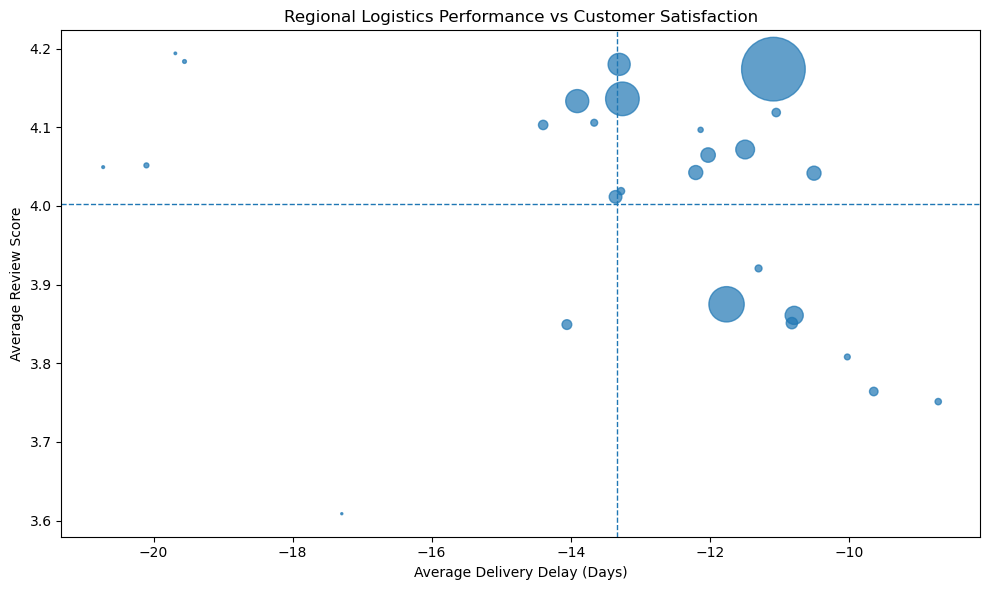

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.scatter(
    regional_perf["avg_delay"],
    regional_perf["avg_review"],
    s=regional_perf["orders"] / 20,
    alpha=0.7
)

plt.axhline(regional_perf["avg_review"].mean(), linestyle="--", linewidth=1)
plt.axvline(regional_perf["avg_delay"].mean(), linestyle="--", linewidth=1)

plt.xlabel("Average Delivery Delay (Days)")
plt.ylabel("Average Review Score")
plt.title("Regional Logistics Performance vs Customer Satisfaction")

plt.tight_layout()

# 👇 ESTA ES LA CLAVE
plt.savefig("../reports/regional_delay_vs_satisfaction.png", dpi=150)

plt.show()

### Insight – Regional Differences

The regional analysis shows that early deliveries alone do not guarantee high customer satisfaction.
While most regions deliver orders ahead of the estimated date, several states still present below-average review scores.

This indicates that customer dissatisfaction is driven by localized issues rather than global logistics failures.
High-volume regions with lower satisfaction represent a meaningful business risk, as their impact is amplified by scale.

Overall, this explains how global sales metrics can remain stable while customer satisfaction declines in specific regions.

## Conclusions

Despite strong average delivery performance and stable sales, customer satisfaction declines in specific regions.
The analysis shows that:

- Orders with worse relative delivery performance receive lower review scores.
- Some regions consistently show lower satisfaction, even without extreme delivery delays.
- Global averages hide localized customer experience issues.

This explains how overall sales can remain stable while satisfaction declines in certain areas.

## Business Recommendations

1. Monitor delivery performance relative to regional benchmarks, not only global averages.
2. Prioritize logistics improvements in low-satisfaction regions, even if delays seem acceptable overall.
3. Introduce regional SLA targets to manage customer expectations.
4. Track satisfaction metrics alongside sales KPIs to detect hidden experience issues early.